**Importing Required Libraries and Dependencies 📦**

In [ ]:
# imports for the practice (you can add more if you need)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import time
import os
import math
from typing import Tuple

# pytorch
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader



# bert & datasets

from datasets import load_dataset
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

In [ ]:
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

**🧠 Loading and Freezing Pre-trained BERT Model**

In [ ]:
from transformers import BertTokenizerFast, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.eval()
bert.to(device)

for param in bert.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**💾 Mounting Google Drive and Loading Tokenized Data**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Deep_Learning/project/data"

from datasets import load_from_disk
#tokenized = load_from_disk(f"{data_path}/tokenized_dataset")
tokenized = load_from_disk(f"{data_path}/tokenized_dataset_")

Mounted at /content/drive


**🛠️ Generating BERT Embeddings for Training Datase**

In [ ]:
from torch.utils.data import DataLoader

tokenized.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label', 'original_index']
)

In [ ]:

# Loader over chunked dataset
chunk_loader = DataLoader(tokenized['train'], batch_size=32, shuffle=False)

lyric_embeddings = defaultdict(list)
lyric_labels = {}

with torch.no_grad():
    for batch in tqdm(chunk_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']
        origins = batch['original_index']

        outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (B, 768)

        for i, origin in enumerate(origins):
            lyric_embeddings[origin].append(cls_embeddings[i].cpu().numpy())
            lyric_labels[origin] = labels[i].item()


100%|██████████| 2066/2066 [33:45<00:00,  1.02it/s]


**📂 Saving Embeddings, Preparing Datasets, and Creating DataLoaders**

In [ ]:
import pickle

# Convert defaultdict to regular dict before saving
with open("lyric_embeddings.pkl", "wb") as f:
    pickle.dump(dict(lyric_embeddings), f)

with open("lyric_labels.pkl", "wb") as f:
    pickle.dump(lyric_labels, f)

In [ ]:
X = []
y = []

for origin in sorted(lyric_embeddings.keys()):
    chunks = np.stack(lyric_embeddings[origin])
    X.append(chunks.mean(axis=0))
    y.append(lyric_labels[origin])

X = np.vstack(X).astype(np.float32)
y = np.array(y, dtype=np.float32)

In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds   = TensorDataset(torch.tensor(X_val),   torch.tensor(y_val))
test_ds  = TensorDataset(torch.tensor(X_test),  torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

**🧠 Defining the MLP Model, Optimizer, and Loss Function**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

model = MLP(input_dim=768).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

**🏋️ Training Loop: Model Learning & Validation Tracking**

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    train_losses = []
    val_losses = []
    val_mses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        val_mse, val_loss = eval_baseline(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_mses.append(val_mse)

        print(f"[Epoch {epoch+1}] Train Loss: {epoch_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MSE: {val_mse:.4f}")

    return train_losses, val_losses, val_mses

**📏 Model Evaluation: Baseline MSE & Loss Calculation**

In [ ]:
def eval_baseline(model, loader, criterion=None):
    model.eval()
    preds, targets = [], []
    running_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds.extend(out.cpu().numpy())
            targets.extend(yb.cpu().numpy())
            if criterion is not None:
                loss = criterion(out, yb)
                running_loss += loss.item() * xb.size(0)

    mse = mean_squared_error(targets, preds)
    val_loss = running_loss / len(loader.dataset) if criterion is not None else None
    return mse, val_loss

**📊 Training & Validation Loss Visualization**

[Epoch 1] Train Loss: 0.0542 | Val Loss: 0.0507 | Val MSE: 0.0507
[Epoch 2] Train Loss: 0.0522 | Val Loss: 0.0526 | Val MSE: 0.0526
[Epoch 3] Train Loss: 0.0515 | Val Loss: 0.0504 | Val MSE: 0.0504
[Epoch 4] Train Loss: 0.0512 | Val Loss: 0.0502 | Val MSE: 0.0502
[Epoch 5] Train Loss: 0.0509 | Val Loss: 0.0504 | Val MSE: 0.0504
[Epoch 6] Train Loss: 0.0504 | Val Loss: 0.0502 | Val MSE: 0.0502
[Epoch 7] Train Loss: 0.0499 | Val Loss: 0.0497 | Val MSE: 0.0497
[Epoch 8] Train Loss: 0.0497 | Val Loss: 0.0496 | Val MSE: 0.0496
[Epoch 9] Train Loss: 0.0493 | Val Loss: 0.0494 | Val MSE: 0.0494
[Epoch 10] Train Loss: 0.0491 | Val Loss: 0.0493 | Val MSE: 0.0493
[Epoch 11] Train Loss: 0.0488 | Val Loss: 0.0506 | Val MSE: 0.0506
[Epoch 12] Train Loss: 0.0486 | Val Loss: 0.0490 | Val MSE: 0.0490
[Epoch 13] Train Loss: 0.0480 | Val Loss: 0.0495 | Val MSE: 0.0495
[Epoch 14] Train Loss: 0.0478 | Val Loss: 0.0493 | Val MSE: 0.0493
[Epoch 15] Train Loss: 0.0475 | Val Loss: 0.0497 | Val MSE: 0.0497
[Epo

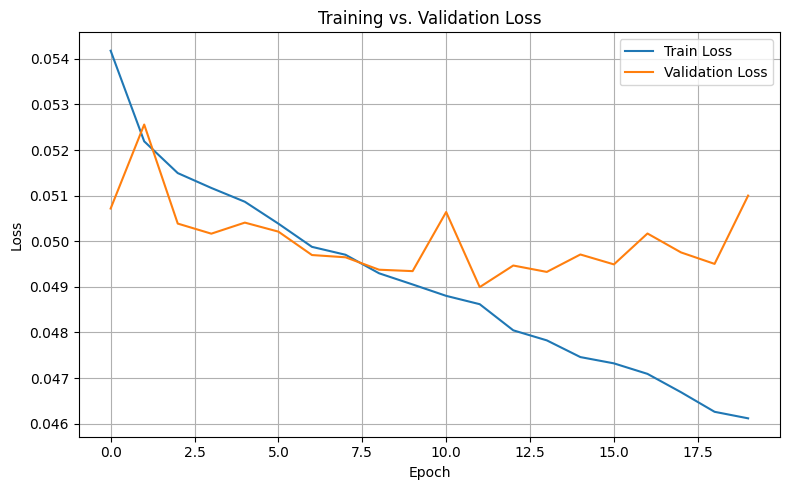

In [ ]:
train_losses, val_losses, val_mses = train_model(
    model, train_loader, val_loader, optimizer, criterion, device, epochs=20
)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_mse, test_loss = eval_baseline(model, test_loader, criterion)
print(f"\n📊 Final Test MSE (Frozen BERT + MLP): {test_mse:.4f}")


📊 Final Test MSE (Frozen BERT + MLP): 0.0517
